Author: Khai Nguyen
Projects:

- Create a autoregressive moving average (ARMA) model to predict PM2.5 levels in Austin, Texas.
- Tune our model hyperparameters to improve performance and communication the result.


# Air Quality: PM2.5

Air Quality: PM2.5 refers to a specific type of air pollutant known as Particulate Matter 2.5. PM2.5 refers to tiny particles suspended in the air that have a diameter of 2.5 micrometers or smaller. These particles are so small that they can be inhaled deep into the lungs and even enter the bloodstream, posing health risks to humans and animals.

PM2.5 particles can come from various sources, including vehicle emissions, industrial processes, construction activities, wildfires, and the burning of fossil fuels and biomass. They can also be formed through chemical reactions in the atmosphere.

The health effects of PM2.5 exposure are significant. When people are exposed to high levels of PM2.5 over a long period or experience short-term exposure during severe pollution events, they may experience respiratory and cardiovascular problems, aggravated asthma, reduced lung function, and an increased risk of heart attacks and strokes.

To monitor air quality, environmental agencies measure the concentration of PM2.5 in the air using specialized instruments. Air quality indexes often include PM2.5 readings to inform the public about the current levels of air pollution and the associated health risks. People can take precautionary measures, such as staying indoors during high pollution periods or wearing masks when necessary, to protect themselves from PM2.5 exposure and its adverse effects.

A "good" PM2.5 value would be one that falls within the range of 0 to 50. **Let's see how good the air in Austin** and **Does the air improve or not since 2022?**


In [2]:
!pip install pymongo

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 603.6/603.6 kB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.0/300.0 kB 27.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.5/74.5 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 6.3 MB/s eta 0:00:00


# What is ARMA model?


the ARMA model stands for Autoregressive Moving Average model. It is a combination of two components: the Autoregressive (AR) component and the Moving Average (MA) component.

In [3]:
import time
import warnings

import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px
import seaborn as sns
from IPython.display import VimeoVideo
from pymongo import MongoClient
from sklearn.metrics import mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

warnings.filterwarnings("ignore")

# Prepare the data


In [44]:
def wrangle(path, resample_rule="1H"):
  # Read the csv file
  df = pd.read_csv(path)

  # Drop the NaN values
  df = df.dropna()

  # Only get the data from AQS
  mask_source = df["Source"] == "AQS"
  df = df[mask_source]

  # Drop the Source column
  df = df.drop(columns=["Source"])

  # Only keep the columns we need
  df = df[["Date","PM2.5"]]

  # Convert date into timestamp and set as index
  df['Date'] = pd.to_datetime(df['Date'].str.strip(), format='%m/%d/%Y')
  df.set_index('Date', inplace=True)

  # Resample and forward-fill
  y = df["PM2.5"].resample(resample_rule).mean().fillna(method="ffill")
  return y


In [49]:
url ="https://raw.githubusercontent.com/Khaihuyennguyen/ARMA_Model_PM2.5_Austin/main/ad_viz_plotval_data_2022.csv"
y = wrangle(url, "1D")
y.info()
y.tail()


<class 'pandas.core.series.Series'>
DatetimeIndex: 485 entries, 2022-01-01 to 2023-04-30
Freq: D
Series name: PM2.5
Non-Null Count  Dtype  
--------------  -----  
485 non-null    float64
dtypes: float64(1)
memory usage: 7.6 KB


Date
2023-04-26    10.533333
2023-04-27     3.266667
2023-04-28     7.700000
2023-04-29     3.833333
2023-04-30     5.166667
Freq: D, Name: PM2.5, dtype: float64

In [50]:
# Check my work
assert isinstance(y, pd.Series), f"`y` should be a Series, not a {type(y)}."

# Exploring the data

## Create an ACF plot for data

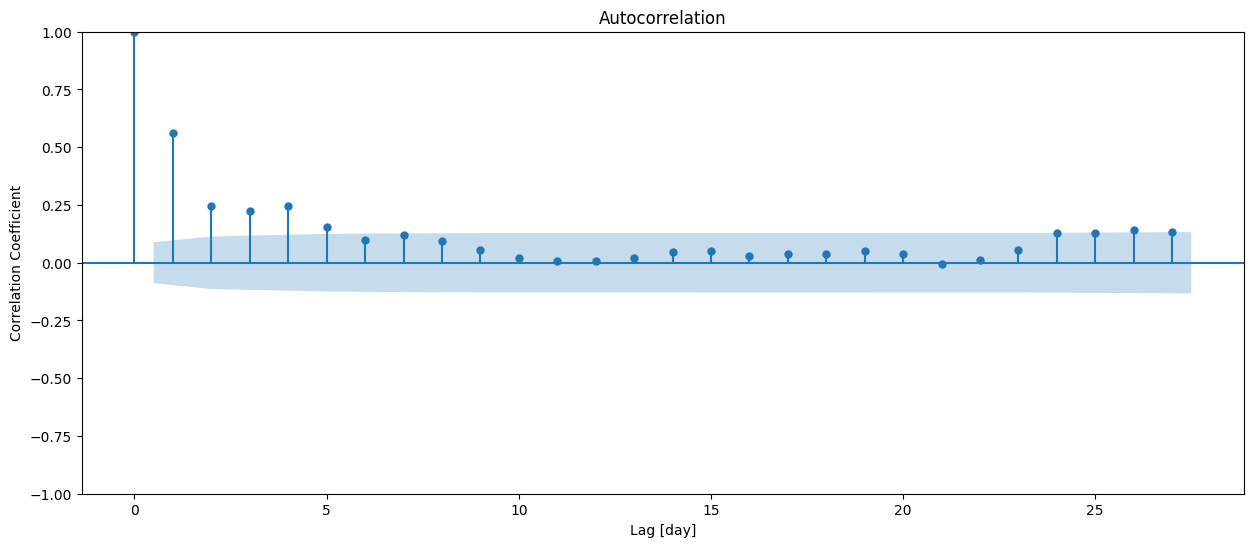

In [54]:
fig, ax = plt.subplots(figsize=(15,6))
plot_acf(y, ax=ax)
plt.xlabel("Lag [day]")
plt.ylabel("Correlation Coefficient")
plt.show()


## Create PACF plot

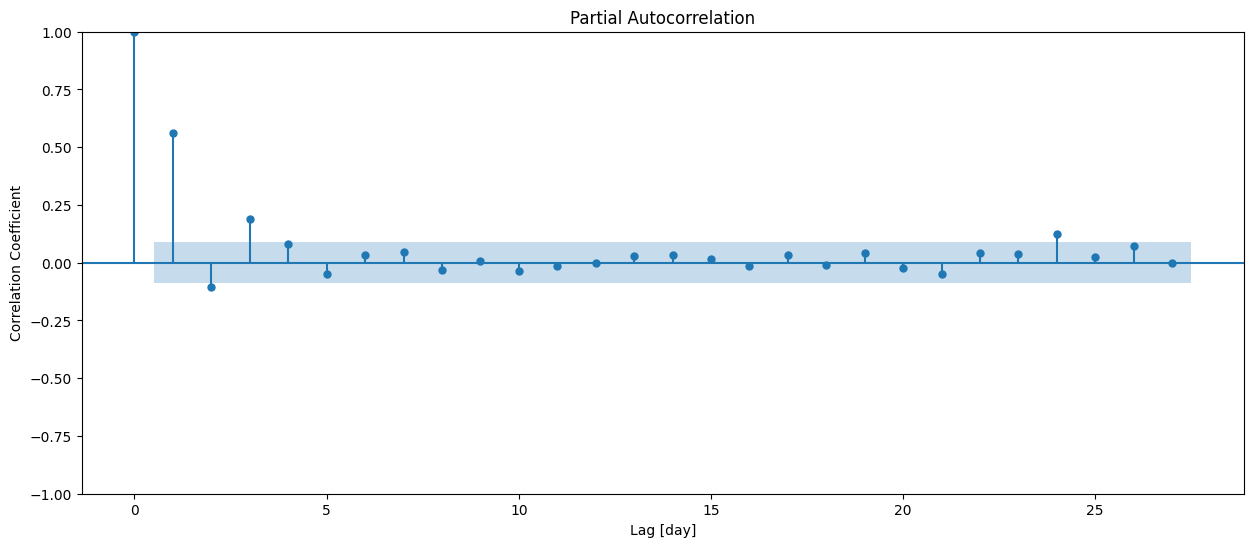

In [53]:
fig, ax = plt.subplots(figsize=(15,6))
plot_pacf(y, ax=ax)
plt.xlabel("Lag [day]")
plt.ylabel("Correlation Coefficient")

plt.show()


# Building Models

## Split data

In [55]:
cutoff_test = int(len(y)*0.95)

y_train = y.iloc[:cutoff_test]
y_test = y.iloc[cutoff_test:]
print(type(y_train))
print(y_train.shape)
print(y_test.shape)

<class 'pandas.core.series.Series'>
(460,)
(25,)


## Baseline

In [56]:
y_train_mean = y_train.mean()
y_pred_baseline = [y_train_mean] * len(y_train)
mae_baseline = mean_absolute_error(y_train, y_pred_baseline)

print("Mean P2 Reading:", round(y_train_mean, 2))
print("Baseline MAE:", round(mae_baseline, 2))

Mean P2 Reading: 8.97
Baseline MAE: 3.35


## Iterate

The AR part of the ARMA model refers to the autoregressive component, which models the relationship between a time series variable and its own past values. It assumes that the current value of the time series can be predicted as a linear combination of its previous values (lags) and a random error term. The **"p" in AR(p) represents the order of the autoregressive component, which indicates how many past values are considered for the prediction**. For example, AR(1) means the model uses only the immediate previous value, AR(2) uses the two previous values, and so on.

The MA part of the ARMA model refers to the moving average component, which models the relationship between a time series variable and the error terms from previous time periods. It assumes that the current value of the time series depends on the error terms from the past, which are assumed to be white noise (random with zero mean and constant variance). T**he "q" in MA(q) represents the order of the moving average component, which indicates how many lagged error terms are considered in the model.** For example, MA(1) means the model uses only the immediate past error term, MA(2) uses the two previous error terms, and so on.

Combining the AR and MA components, an ARMA(p, q) model is represented as follows:

y_t = c + ϕ_1 * y_(t-1) + ϕ_2 * y_(t-2) + ... + ϕ_p * y_(t-p) + θ_1 * e_(t-1) + θ_2 * e_(t-2) + ... + θ_q * e_(t-q) + e_t

where:

y_t is the value of the time series variable at time t.

c is the constant term (intercept) in the model.

ϕ_1, ϕ_2, ..., ϕ_p are the autoregressive coefficients.

e_t is the error term (white noise) at time t.

θ_1, θ_2, ..., θ_q are the moving average coefficients.

Estimating the values of the coefficients (ϕ's and θ's) is done using various statistical methods, and the optimal order of the ARMA model (values of p and q) is determined through model selection techniques like information criteria or cross-validation.







In [57]:
# Create a range of p and q values. p should be in range between 0 and 25, by steps of 8. q should range between 0 and 3 steps by 1
p_params = range(0,25,8)
q_params = range(0, 3, 1)

Train a model with every combination of hyperparameters in p_params and q_params. Every time the model is trained, the mean absolute error is calculated and then saved to a dictionary. If you're not sure where to start, do the code-along with Nicholas!

In [58]:
# Create dictionary to store MAEs
mae_grid = dict()
# Outer loop: Iterate through possible values for `p`
for p in p_params:
    # Create key-value pair in dict. Key is `p`, value is empty list.
    mae_grid[p] = list()
    # Inner loop: Iterate through possible values for `q`
    for q in q_params:
        # Combination of hyperparameters for model
        order = (p, 0, q)
        # Note start time
        start_time = time.time()
        # Train model
        model = ARIMA(y_train, order=order).fit()
        # Calculate model training time
        elapsed_time = round(time.time() - start_time, 2)
        print(f"Trained ARIMA {order} in {elapsed_time} seconds.")
        # Generate in-sample (training) predictions
        y_pred = model.predict()
        # Calculate training MAE
        mae = mean_absolute_error(y_train, y_pred)
        # Append MAE to list in dictionary
        mae_grid[p].append(mae)

print()
print(mae_grid)

Trained ARIMA (0, 0, 0) in 0.27 seconds.
Trained ARIMA (0, 0, 1) in 0.41 seconds.
Trained ARIMA (0, 0, 2) in 0.81 seconds.
Trained ARIMA (8, 0, 0) in 3.45 seconds.
Trained ARIMA (8, 0, 1) in 6.61 seconds.
Trained ARIMA (8, 0, 2) in 5.61 seconds.
Trained ARIMA (16, 0, 0) in 6.63 seconds.
Trained ARIMA (16, 0, 1) in 12.58 seconds.
Trained ARIMA (16, 0, 2) in 14.15 seconds.
Trained ARIMA (24, 0, 0) in 11.42 seconds.
Trained ARIMA (24, 0, 1) in 20.56 seconds.
Trained ARIMA (24, 0, 2) in 24.53 seconds.

{0: [3.352913732096853, 2.828344785670806, 2.758222394707655], 8: [2.728638436333497, 2.7303990033192407, 2.7307176092876024], 16: [2.722155014206053, 2.7270302147055525, 2.725255362223791], 24: [2.7273894626223147, 2.7216981871614743, 2.716058699892391]}


Organize all the MAE from above in a DataFrame names mae_df. Each row represents a possible value for q and each colum for p

In [60]:
mae_df = pd.DataFrame(mae_grid)
mae_df.round(4)

,0,8,16,24
0,3.3529,2.7286,2.7222,2.7274
1,2.8283,2.7304,2.7270,2.7217
2,2.7582,2.7307,2.7253,2.7161


To visualize the results better, we create heatmap

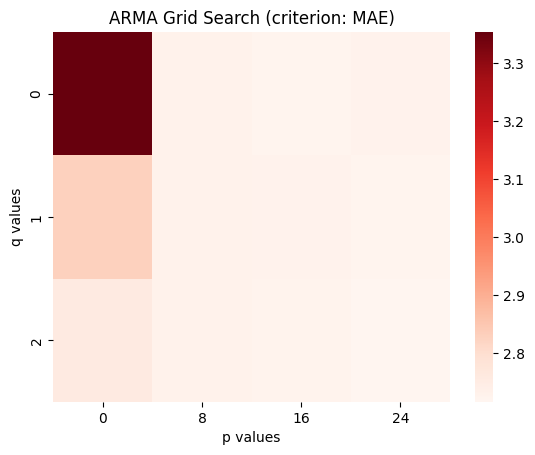

In [62]:
sns.heatmap(mae_df, cmap="Reds")
plt.xlabel("p values")
plt.ylabel("q values")
plt.title("ARMA Grid Search (criterion: MAE)");

We see that the model did not perform well at p=0, but better at 8 and higher. In term of best result, at p=24 and q = 2 we have MAE= 	2.7161. However, in term of utilizing resources, I prefer the value at p = 16, and q=0 where MAE =2.7222.

Use the plot_diagnostics method to check the residuals for the best models.

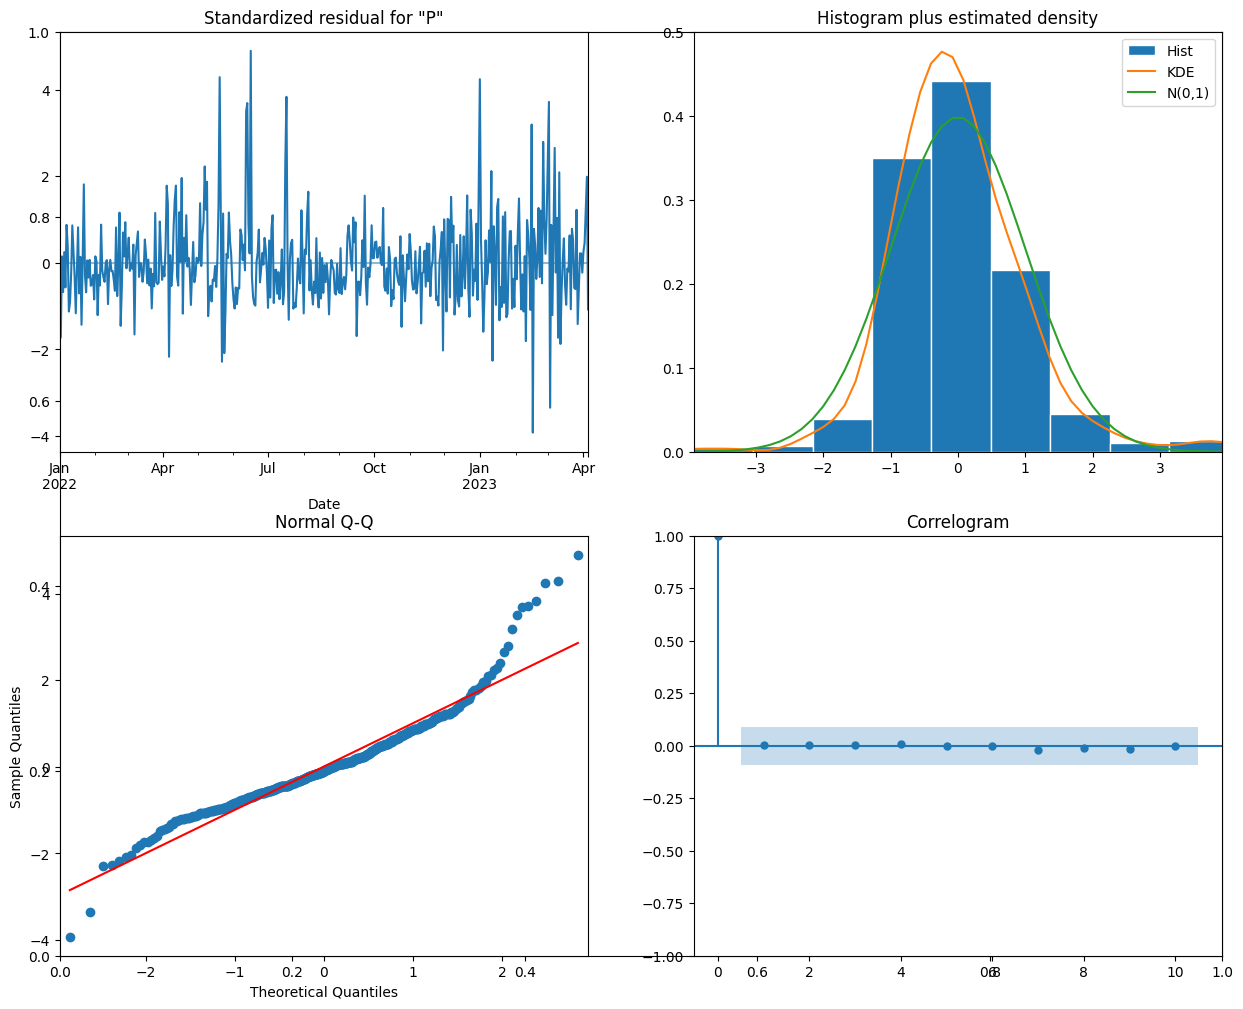

In [64]:
fig, ax = plt.subplots(figsize=(15, 12))
model.plot_diagnostics(fig=fig);



*   For the standardized residual for "P" looks not so bad although we have a lot of outlier. So, more data and wrangling for outlier will help.
*   Correlogram shows that the model perform well.



# Evaluate

Perform walk-forward validation for my model for the entire test set `y_test`. Store my model's predictions in the Series `y_pred_wfv`. Choose the values for $p$ and $q$ that best balance model performance and computation time.

In [66]:
y_pred_wfv = pd.Series()
history = y_train.copy()
for i in range(len(y_test)):
    model = ARIMA(history, order=(16, 0, 0)).fit()
    next_pred = model.forecast()
    y_pred_wfv = y_pred_wfv.append(next_pred)
    history = history.append(y_test[next_pred.index])

In [67]:
test_mae = mean_absolute_error(y_test, y_pred_wfv)
print("Test MAE (walk forward validation):", round(test_mae, 2))

Test MAE (walk forward validation): 2.2


# Communication Result

First, generate the list of training predictions for my model. Next, create a DataFrame df_predictions with the true values y_test and your predictions y_pred_wfv (don't forget the index). Finally, plot df_predictions using plotly express

In [69]:
df_predictions = pd.DataFrame({"y_test": y_test, "y_pred_wfv": y_pred_wfv})
fig = px.line(df_predictions, labels={"Values": "PM2.5"})
fig.show()

####  In my project on air quality analysis in Austin, I followed a comprehensive approach, covering various steps:

Data Acquisition: I obtained the air quality data for Austin, which includes pollutants like PM2.5, from reliable sources https://aqs.epa.gov/aqsweb/documents/data_api.html

Data Wrangling: I cleaned and preprocessed the data to handle missing values, outliers, and any other data quality issues, ensuring the data's suitability for analysis and modeling.

Model Tuning: I selected appropriate time series models, such as ARIMA, or  and tuned their parameters to achieve the best possible performance. Parameter tuning was essential for improving the accuracy of my models.

Data Visualization: I created visualizations, including time series plots and correlograms, to gain insights into the patterns and trends in the air quality data. Visualizations helped convey insights effectively.

Resource-Performance Trade-off: I considered the trade-off between model complexity and performance. More complex models might provide better accuracy, but they may also require more computational resources and be harder to interpret.

Model Evaluation: I evaluated the performance of my models using appropriate metrics, such as Mean Absolute Error (MAE). Model evaluation helped me understand how well my models were capturing the air quality patterns.


Overall, my project demonstrated a thorough and systematic approach to analyzing air quality data using time series models. I covered critical aspects of the analysis, including data preparation, modeling, and evaluation. My insights can be valuable for understanding air quality trends in Austin and potentially for making informed predictions. I'm pleased with completing such a comprehensive project!